# Imports

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import skimage

# Functions

In [2]:
#Function to show an Image in a figure
def show_image(image, title='Image', cmap_type='gray'):
    plt.figure()
    plt.imshow(image, cmap = cmap_type)
    plt.title(title)
    plt.show(block=True)

In [3]:
#Check if the Variable is empty , whether tuple or nparray
def is_notEmpty(Variable):
    if(Variable is None):
        return False
    else:
        return True

In [4]:
#Prints all the np array exceeding the limit
def print_all(arr):
    with np.printoptions(threshold=np.inf):
        print(arr)

In [5]:
#Divides the video to frame(images) array
def videoToFrames(video,startFrame = 0,numOfFrames = -1):
    framePerSecond = int(video.get(cv2.CAP_PROP_FPS))
    frameCount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    frames = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
    fc = 0
    ret = True
    while (fc < frameCount  and ret):
        ret, frames[fc] = video.read()
        fc += 1

    video.release()
    
    framesRGB= np.copy(frames)
    for i in range(len(frames)):
        framesRGB[i] = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
    
    if (numOfFrames ==-1):
        return framesRGB[startFrame:],framePerSecond , frameCount
    else:
        return framesRGB[startFrame:startFrame+numOfFrames], framePerSecond , frameCount

In [6]:
#Take the frames(images) array and combines into video according to the frames per second
def makeVideo (frames,framePerSecond, video_name ='Output Video'):
    video_name_path = video_name + '.avi'
    
    framesBGR= np.copy(frames)
    for i in range(len(frames)):
        framesBGR[i] = cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR)
    
    height, width, layers = frames[0].shape
    video = cv2.VideoWriter(video_name_path, cv2.VideoWriter_fourcc('M','J','P','G'), framePerSecond, (width,height))
    for i,frame in enumerate(framesBGR):
        video.write(frame)
    video.release()

In [7]:
# Apply gaussian blur to eliminate noise
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [8]:
# Apply canny to find edges
def canny(image):    
    #derivative small deriv small change big deriv is an edge
    canny_img = cv2.Canny(image, 50, 150)
    return canny_img

In [9]:
# Returns list from range minRange and maxRange
def getListInRange(minRange,maxRange):
    List = []
    for i in range(maxRange -minRange + 1):
        List.append(minRange + i)
    return List

In [10]:
# Generates a blank black image
def generateEmptyImage(height,width):
    return np.zeros((height,width,3), dtype=np.uint8)

In [11]:
# gets X points and gets Y points from (X,Y) points
def getXYPoints(PointsArr):
    x,y = np.hsplit(PointsArr,2)
    x = np.transpose(x)[0]
    y = np.transpose(y)[0]
    return x ,y

In [12]:
# Detects starting points for lane and end points
# Returns All points detected in lane lines
def getPolyPoints(image, maxLaneWidth,minLaneWidth,goAbove):
        
    height, width = image.shape[:2]
    
    # Points = (LeftLineStart,RightLineStart,LeftLineEnd,RightLineEnd)
    Points = [(-1,-1),(-1,-1),(-1,-1),(-1,-1)]
    
    AllPointsLeft = []
    AllPointsRight = []
    
    i = height-1
    limit = 500
    HorizontalDifference = 15 
    leftFound = False # found left lane pixel in this height
    RightFound = False # found right lane pixel in this height
    endMet = False # reached minimum lane or less
    blockRemoved = 0 #remove from middle
    
    while ((i > limit) and ((Points[0][0] == -1) or (Points[1][0] == -1) or (not endMet))):
        leftFound = False
        RightFound = False
        for j in range(maxLaneWidth//2):
            if ((image[i,((width//2) -1) - j] == 1) and (not leftFound)):
                if(Points[0][0] == -1): # or (Points[1][0] == -1):
                    Points[0] = (((width//2) -1) - j,i)
                    AllPointsLeft.append((((width//2) -1) - j,i))
                    Points[2] = (((width//2) -1) - j,i)
                    leftFound = True
                    
                elif ((((width//2) -1) - j) > (AllPointsLeft[-1][0] - HorizontalDifference)):
                    AllPointsLeft.append((((width//2) -1) - j,i))
                    Points[2] = (((width//2) -1) - j,i)
                    leftFound = True

                
            if ((image[i,((width//2) -1) + j] == 1) and (not RightFound)):               
                if(Points[1][0] == -1): #or (Points[0][0] == -1):
                    Points[1] = (((width//2) -1) + j,i)
                    AllPointsRight.append((((width//2) -1) + j,i))
                    Points[3] = (((width//2) -1) + j,i)
                    RightFound = True
                    
                elif ((((width//2) -1) + j) < (AllPointsRight[-1][0] + HorizontalDifference)):
                    AllPointsRight.append((((width//2) -1) + j,i))
                    Points[3] = (((width//2) -1) + j,i)
                    RightFound = True

            if ((np.absolute(Points[2][0] - Points[3][0]) < minLaneWidth) 
                and ((Points[0][0] != -1) and (Points[1][0] != -1))):
                endMet = True
        i -=1
    return Points, AllPointsLeft , AllPointsRight

In [13]:
# Calculate curve fitting for the points
def getPointsCurve(x,y,StartPoint, EndPoint):
    fit = np.polyfit(y, x, 2)
    a = fit[0]
    b = fit[1]
    c = fit[2]
    
    NewY = np.array(getListInRange(EndPoint[1],StartPoint[1]))
    fit_equation = (a * np.square(NewY) + b * NewY + c).astype(np.uint16)
    NewPoints = np.dstack((fit_equation,NewY))
    return NewPoints,fit

In [14]:
# Draw lines from start to end and extends the line whether start or end 
#if either lane line has different starting or ending point
def DrawLines (Points, AllPointsLeft, AllPointsRight, height = 720, width =1280):
    
    # Generate Blank Image
    image = generateEmptyImage(height, width)
    
    linesColor = (255, 0, 0)
    linesThickness = 10
    
    # newPoints = (LeftLineStart,RightLineStart,LeftLineEnd,RightLineEnd)
    newPoints = [(),(),(),()]
    
    if not(AllPointsLeft):
        return
    elif not(AllPointsRight):
        return
    
    # extend the line from the start
    if (Points[0][1] != Points[1][1]):
        #different start        
        if (Points[0][1] < Points[1][1]) :
            # Extend Left
                            
            #while Two points get slope = 0 or divides 0 --> get next point available
            attemptLeft = 0
            while (True):
                if not(((AllPointsLeft[attemptLeft][0] - Points[2][0]) == 0) 
                       or  ((AllPointsLeft[attemptLeft][1] - Points[2][1]) == 0)):
                    break
                else:
                    if (attemptLeft < len(AllPointsLeft)-1):
                        attemptLeft +=1
                    else:
                        return
            slope= (AllPointsLeft[attemptLeft][1] - Points[2][1]) / (AllPointsLeft[attemptLeft][0] - Points[2][0])
            # slope = (y2 - y1) / (x2 - x1) ---> solve for x2 then x2 = (y2 - y1/ slope) + x1
            NewX = int(((Points[1][1]-AllPointsLeft[attemptLeft][1])/ slope) + AllPointsLeft[attemptLeft][0])
            newPoints[0] = (NewX,Points[1][1])
            newPoints[1] = Points[1]
        else :
            # Extend Right
            
            #while Two points get slope = 0 or divides 0 --> get next point available
            attemptRight = 0
            while (True):
                if not(((AllPointsRight[attemptRight][0] - Points[3][0]) == 0) 
                       or ((AllPointsRight[attemptRight][1] - Points[3][1]) == 0)):
                    break
                else:
                    if (attemptRight < len(AllPointsRight)-1):
                        attemptRight +=1
                    else:
                        return
            
            slope= (AllPointsRight[attemptRight][1] - Points[3][1]) / (AllPointsRight[attemptRight][0] - Points[3][0])
            # slope = (y2 - y1) / (x2 - x1) ---> solve for x2 then x2 = (y2 - y1/ slope) + x1
            NewX = int(((Points[0][1]-AllPointsRight[attemptRight][1])/ slope) + AllPointsRight[attemptRight][0])
            newPoints[0] = Points[0]
            newPoints[1] = (NewX,Points[0][1])
    else:
        newPoints[0] = Points[0]
        newPoints[1] = Points[1]
    
    # extend the line end
    if (Points[2][1] != Points[3][1]):
        #different end
        if (Points[2][1] > Points[3][1]) :
            # Extend Left
            #while Two points get slope = 0 or divides 0 --> get next point available
            attemptLeft = 0
            while (True):
                if not(((AllPointsLeft[attemptLeft][0] - Points[2][0]) == 0) 
                       or  ((AllPointsLeft[attemptLeft][1] - Points[2][1]) == 0)):
                    break
                else:
                    if (attemptLeft < len(AllPointsLeft)-1):
                        attemptLeft +=1
                    else:
                        return
                        
            slope= (AllPointsLeft[attemptLeft][1] - Points[2][1]) / (AllPointsLeft[attemptLeft][0] - Points[2][0])
            # slope = (y2 - y1) / (x2 - x1) ---> solve for x2 then x2 = (y2 - y1/ slope) + x1
            NewX = int(((Points[3][1]-AllPointsLeft[attemptLeft][1])/ slope) + AllPointsLeft[attemptLeft][0])
            newPoints[2] = (NewX,Points[3][1])
            newPoints[3] = Points[3]
        else :
            # Extend Right
            #while Two points get slope = 0 or divides 0 --> get next point available
            attemptRight = 0
            while (True):
                if not(((AllPointsRight[attemptRight][0] - Points[3][0]) == 0) 
                       or ((AllPointsRight[attemptRight][1] - Points[3][1]) == 0)):
                    break
                else:
                    if (attemptRight < len(AllPointsRight)-1):
                        attemptRight +=1
                    else:
                        return
            
            slope= (AllPointsRight[attemptRight][1] - Points[3][1]) / (AllPointsRight[attemptRight][0] - Points[3][0])
            # slope = (y2 - y1) / (x2 - x1) ---> solve for x2 then x2 = (y2 - y1/ slope) + x1
            NewX = int(((Points[2][1]-AllPointsRight[attemptRight][1])/ slope) + AllPointsRight[attemptRight][0])
            newPoints[2] = Points[2]
            newPoints[3] = (NewX,Points[2][1])
    else:
        newPoints[2] = Points[2]
        newPoints[3] = Points[3]
    
    cv2.line(image, newPoints[0], newPoints[2], linesColor, thickness=linesThickness)
    cv2.line(image, newPoints[1], newPoints[3], linesColor, thickness=linesThickness)

    return image , newPoints

In [15]:
#Draws the curve from the curve fitting function
def DrawCurves(PointsLeft, PointsRight, height, width ,thickness = 10):
    
    # Generate Blank Image
    image = generateEmptyImage(height, width)
  
    isClosed = False
  
    color = (255, 0, 0)

    # Using cv2.polylines() method
    image = cv2.polylines(image, [PointsLeft], isClosed, color, thickness)
    image = cv2.polylines(image, [PointsRight], isClosed, color, thickness)
    return image

In [16]:
# Gets median X value for all Points
def getMedianHeightfilter(Points,xPoints,yPoints,numPoints):
    newPoints= []
    newxPoints = np.copy(xPoints)
    newyPoints = np.copy(yPoints)
    for i in range(len(Points)):
        if ((i - numPoints//2)  <0): # At start and need padding --> take numPoints from right
            newxPoints[i] = (np.median(newxPoints[0:numPoints]))
            newPoints.append((newxPoints[i],newyPoints[i]))
    
        else:
            newxPoints[i] = (np.median(xPoints[(i - (numPoints//2)):(i + (numPoints//2) + 1)]))
            newPoints.append((newxPoints[i],newyPoints[i]))
            
    return newPoints,newxPoints,newyPoints

In [17]:
#Calculates Radius of Curvature
def getRadiusofCurvature(PolynomialFit):
    # Radius of curvature = ((1+ (dy/dx)**2)**(3/2))/(abs.(dy2/dx2))
    firstDegree=np.polyder(PolynomialFit,1)
    SecondDegree=np.polyder(PolynomialFit,2)
    
    # Assumption : We calculate Radius from the peak of parbola
    # x = -b / 2a
    x = (-PolynomialFit[1])/ (2*PolynomialFit[0])
    return ((1+ (np.polyval(firstDegree,x))**2)**(3/2))/(np.abs(np.polyval(SecondDegree,x)))

## Read an Image

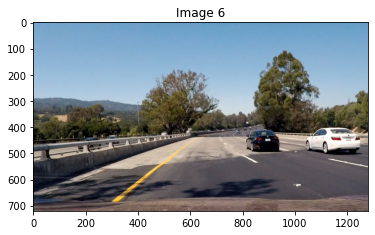

In [18]:
# Reading an image
images_paths = glob.glob("media/test_images/*.jpg")
images = [plt.imread(image) for image in images_paths]

image_idx = 5

show_image(images[image_idx], "Image " + str(image_idx + 1))

## Read a Video

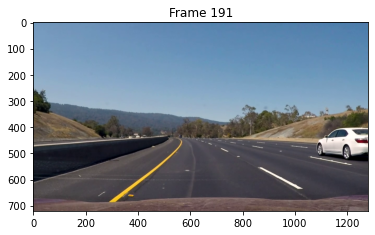

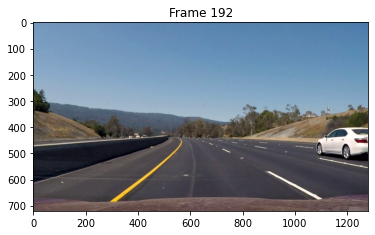

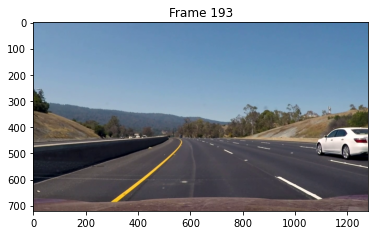

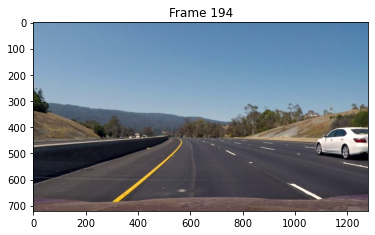

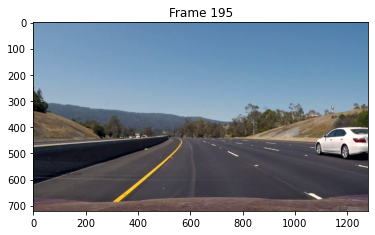

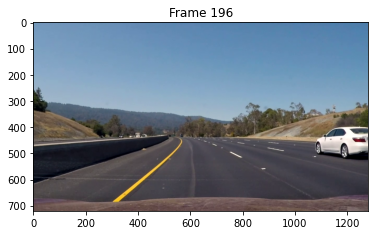

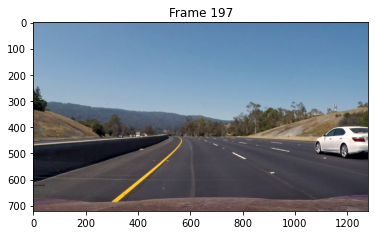

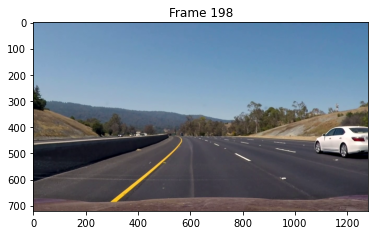

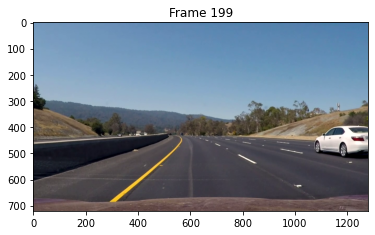

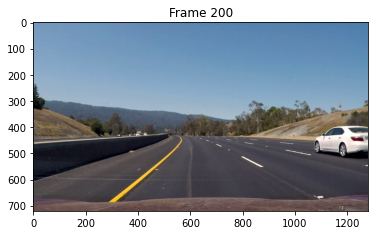

In [19]:
VideoFlag = True

if (VideoFlag):
    video_paths = glob.glob("media/*.mp4")
    videos = [cv2.VideoCapture(video) for video in video_paths]
    numOfFrames = 10
    startFrame = 190
    frames, fps, frameCount = videoToFrames(videos[0],190,10)    
    plt.rcParams['figure.max_open_warning'] = fps
    for i, frame in enumerate(frames):
        show_image(frame, "Frame "+ str(i+1+startFrame))

## Making Video from frames

In [20]:
if (VideoFlag):
    makeVideo(frames,fps)

# Pipeline Step by Step

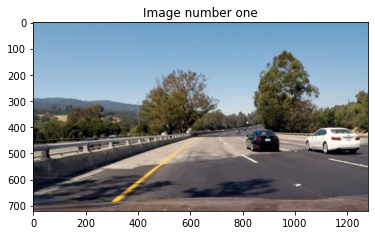

In [21]:
method = 4
#Method 1 --> Line fitting Method
#Method 2 --> Curve fitting Method
#Method 3 --> Point fitting Method
#Method 4 --> All Methods

#Checks if method has a valid value
if not(0 < method < 5):
    raise ValueError('Method must be in the range [1,4]')
    
#Intializes the need for horizontal median
NeedHorizontalMedian = True
    
# Blurs the image using Gaussian blur with kernal size 5    
blur_img = gaussian_blur(images[image_idx], 5)
show_image(blur_img, "Image number one")

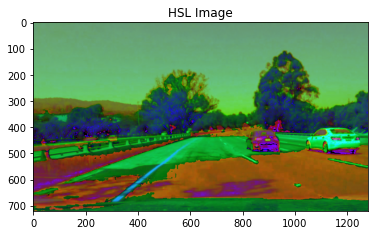

In [22]:
# Converts the image from RGB to HLS color
hls_img = cv2.cvtColor(blur_img, cv2.COLOR_RGB2HLS)

# Gets S channel from HLS
s_channel = hls_img[:, :, 2]

show_image(hls_img, "HSL Image")

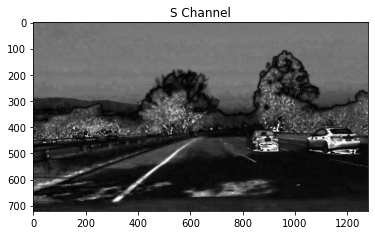

In [23]:
show_image(s_channel, "S Channel")

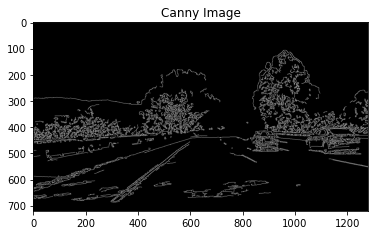

In [24]:
# Applys Canny Edge detection on S channel
canny_img = canny(s_channel)
show_image(canny_img, "Canny Image")

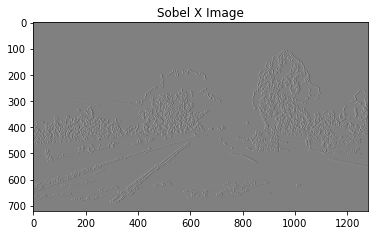

In [25]:
# Applys Sobel to find vertical edges
sobelx = cv2.Sobel(canny_img, cv2.CV_64F, 1, 0)
show_image(sobelx, "Sobel X Image")

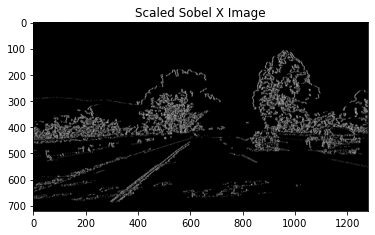

In [26]:
# Normalizes Sobel from 0 to 255 to Visualize the image
abs_sobel_x = np.absolute(sobelx)
scaled_sobel = (255 * ((abs_sobel_x) / np.max(abs_sobel_x))).astype(np.uint8)
show_image(scaled_sobel, "Scaled Sobel X Image")

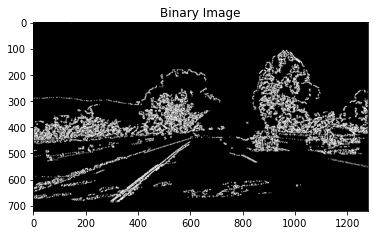

In [27]:
# Does threshold to eliminate pixels out of range
sx_thresh = [20, 200]

sx_binary = np.zeros_like(scaled_sobel)
sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1
show_image(sx_binary, "Binary Image")

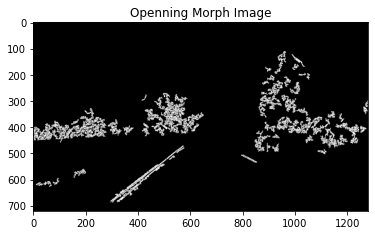

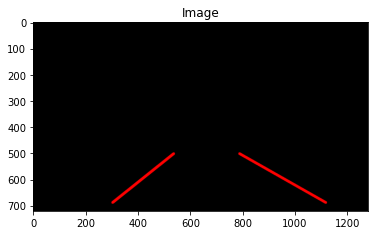

In [28]:
# Gets the Polygon Points and All points in lane lines
Points , AllPointsLeft, AllPointsRight = getPolyPoints(sx_binary,850,120,80)
## If slope = 0 or points on same line ---> dividing over 0
if (((Points[0][0] - Points[2][0]) == 0) or ((Points[1][0] - Points[3][0]) == 0)
    or ((Points[0][1] - Points[2][1]) == 0) or ((Points[1][1] - Points[3][1]) == 0)):
    NeedHorizontalMedian = False # No need for horizontal median after Openning
    OpenningMorph = skimage.morphology.diameter_opening(sx_binary,24,1) #Does Openning Morph to eliminate noise
    show_image(OpenningMorph, "Openning Morph Image")
    #Recalculates the Polygon Points and All points in lane lines after the Morph
    Points , AllPointsLeft, AllPointsRight = getPolyPoints(OpenningMorph,850,120,80)

# Draw lines based on the lanes line given
LinesDrawnTest = DrawLines(Points,AllPointsLeft,AllPointsRight,sx_binary.shape[0],sx_binary.shape[1])
# Checks if it was able to draw line
if (LinesDrawnTest):
    # It drew the lines successfully
    LanesDrawn, newPoints = LinesDrawnTest
    show_image(LanesDrawn)
else:
    # Couldn't draw lines and frame or image didn't work
    print("The image has error in detecting lane")

In [29]:
# Adjusts the Point in order to draw the polygon
AdjustedPoints = np.array([(newPoints[0]),(newPoints[2]),(newPoints[3]),(newPoints[1])])
print(AdjustedPoints)

[[ 304  687]
 [ 537  501]
 [ 789  501]
 [1118  687]]


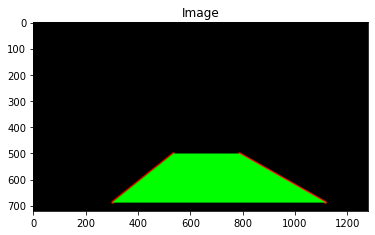

In [30]:
# Fills the Polygon with green color on the lines drawn
cv2.fillPoly(LanesDrawn, pts = [AdjustedPoints] ,color=(0, 255, 0))
show_image(LanesDrawn)

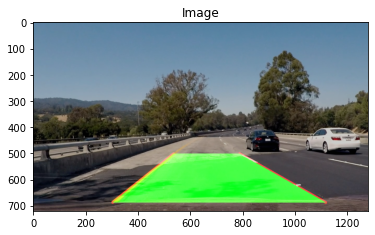

In [31]:
# Combines the filled polygon and lines with the Frame or Image 
combine = cv2.addWeighted(images[image_idx],0.8, LanesDrawn, 1,1)
show_image(combine)

In [32]:
# Adjusts All left points and Right points as np Array
AdjustedLeftPoints = np.array(AllPointsLeft)
AdjustedRightPoints = np.array(AllPointsRight)

# Gets X and Y seprately for left and right lines
LeftX , LeftY = getXYPoints(AdjustedLeftPoints)
RightX , RightY = getXYPoints(AdjustedRightPoints)

(696.3, 491.7)

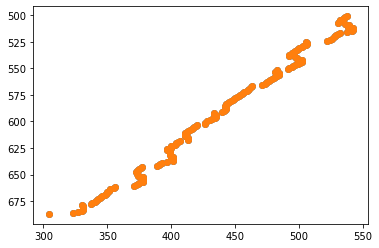

In [33]:
# Does Horizontal Median to eliminate isolated points detected for the Left points
if (NeedHorizontalMedian):
    NewAdjustedLeftPoints, NewLeftX,NewLeftY = getMedianHeightfilter(AdjustedLeftPoints,LeftX,LeftY,9)
else:
    NewAdjustedLeftPoints, NewLeftX,NewLeftY = AdjustedLeftPoints,LeftX,LeftY

# Plots the New Adjusted Left Points against the Left Adjusted Points
plt.scatter(LeftX,LeftY)
plt.scatter(NewLeftX, NewLeftY)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

(536.5, 503.5)

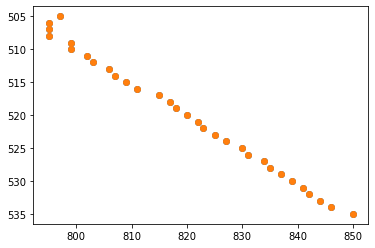

In [34]:
# Does Horizontal Median to eliminate isolated points detected for the Right points
if (NeedHorizontalMedian):
    NewAdjustedRightPoints, NewRightX,NewRightY = getMedianHeightfilter(AdjustedRightPoints,RightX,RightY,9)
else:
    NewAdjustedRigthPoints, NewRightX,NewRightY = AdjustedRightPoints,RightX,RightY

# Plots the New Adjusted Right Points against the Right Adjusted Points
plt.scatter(RightX, RightY)
plt.scatter(NewRightX, NewRightY)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

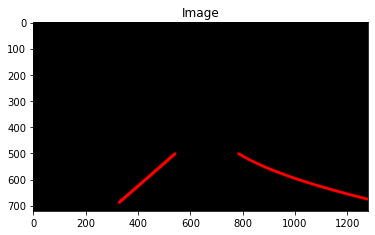

In [35]:
# Does curve fitting for the Left lane line and the Right lane line
LeftPointsCurve , LeftPolynomial = getPointsCurve(NewLeftX,NewLeftY,AdjustedPoints[0],AdjustedPoints[1])
RightPointsCurve, RightPolynomial = getPointsCurve(NewRightX,NewRightY,AdjustedPoints[3],AdjustedPoints[2])

# Draw the curves on an empty image
LanesDrawn2 = DrawCurves(LeftPointsCurve,RightPointsCurve,sx_binary.shape[0],sx_binary.shape[1])
show_image(LanesDrawn2)

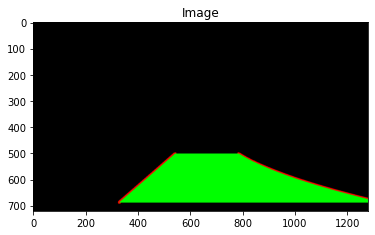

In [36]:
# Adjusts the points in order to draw the Polygon of curved lines
AdjustedAllPointsCurved = np.hstack((LeftPointsCurve, np.flip(RightPointsCurve,1)))

# Draws the Polygon on the curved lines image
cv2.fillPoly(LanesDrawn2, pts = [AdjustedAllPointsCurved] ,color=(0, 255, 0))
show_image(LanesDrawn2)

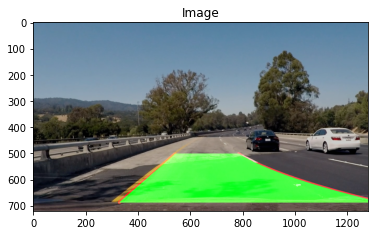

In [37]:
# Combines the filled polygon and curved lines with the Frame or Image 
combine2 = cv2.addWeighted(images[image_idx],0.8, LanesDrawn2, 1,1)
show_image(combine2)

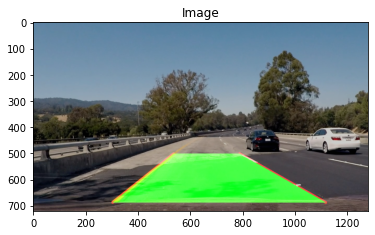

In [38]:
show_image(combine)

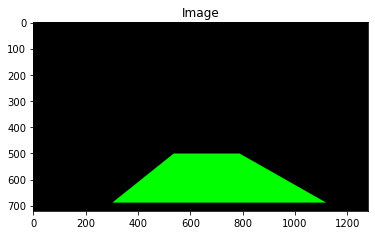

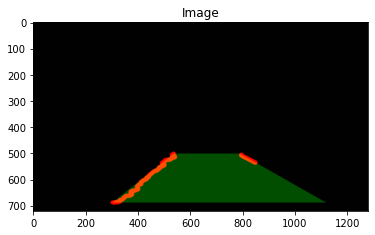

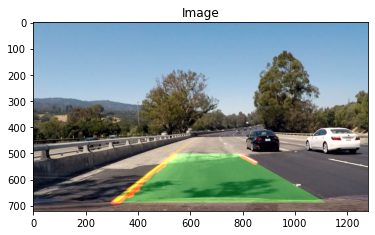

In [39]:
# Checks if needs to do Point fitting
if (method==3 or method ==4):
    #Gets All Left and Right Points
    LeftPointsCurve2 = np.dstack((NewLeftX,NewLeftY))
    RightPointsCurve2 = np.dstack((NewRightX,NewRightY))
    
    # Draws the Polygon achieved from line fitting methond on blank image
    LanesDrawnPoly3 = generateEmptyImage(sx_binary.shape[0],sx_binary.shape[1])
    cv2.fillPoly(LanesDrawnPoly3, pts = [AdjustedPoints] ,color=(0, 255, 0))
    show_image(LanesDrawnPoly3)
    # Combines the Polygon with Curve produced of connecting all points detected
    LanesDrawn3 = DrawCurves(LeftPointsCurve2,RightPointsCurve2,sx_binary.shape[0],sx_binary.shape[1],15)
    LanesDrawn3 = cv2.addWeighted(LanesDrawnPoly3,0.3, LanesDrawn3, 1,1)
    show_image(LanesDrawn3)
    # Combines the filled polygon and point filled lines with the Frame or Image
    combine3 = cv2.addWeighted(images[image_idx],1, LanesDrawn3, 1,1)
    show_image(combine3)

### Calculate Radius of Curvature

In [40]:
# Calculates Radius of Curvature using the Curve produced by Curve fitting
RadiusLeft = round(getRadiusofCurvature(LeftPolynomial),2)
RadiusRight = round(getRadiusofCurvature(RightPolynomial),2)

# Intializes Radius of Curvature to the highest of the left or right radius
RadiusHighest = round(max(RadiusLeft,RadiusRight)/1000,2)

### Displaying Radius of Curvature on Image

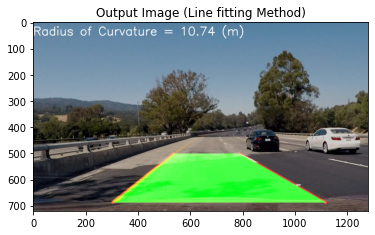

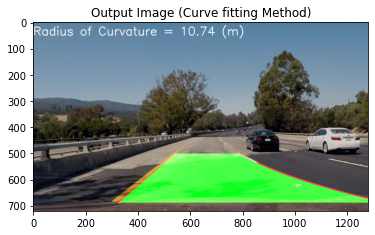

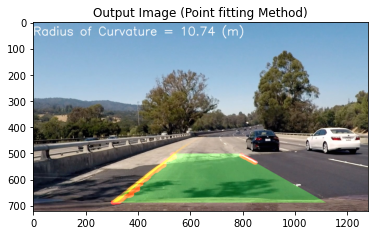

In [41]:
# Adds Radius of Curvature text on the image or frame
if (method == 1 or method==4):
        Radius_img1=np.copy(combine)
        cv2.putText(Radius_img1, "Radius of Curvature = "+str(RadiusHighest) +" (m)", (0,50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
        show_image(Radius_img1,"Output Image (Line fitting Method)")
    
if (method == 2 or method==4):
    Radius_img2=np.copy(combine2)
    cv2.putText(Radius_img2, "Radius of Curvature = "+str(RadiusHighest) +" (m)", (0,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    show_image(Radius_img2,"Output Image (Curve fitting Method)")

if (method == 3 or method==4):
    Radius_img3=np.copy(combine3)
    cv2.putText(Radius_img3, "Radius of Curvature = "+str(RadiusHighest) +" (m)", (0,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    show_image(Radius_img3,"Output Image (Point fitting Method)")

# Pipeline in One Step

In [42]:
def pipeline(image,method=2,debugger = False):
    #Method 1 --> Line fitting Method
    #Method 2 --> Curve fitting Method
    #Method 3 --> Point fitting Method
    #Method 4 --> All Methods
    
    #Checks if method has a valid value
    if not(0 < method < 5):
        raise ValueError('Method must be in the range [1,4]')
    
    #Intializes the need for horizontal median
    NeedHorizontalMedian = True
    
    # Blurs the image using Gaussian blur with kernal size 5
    blur_img = gaussian_blur(image, 5)
    if (debugger):
        show_image(blur_img,"Gaissian Blur")
    
    # Converts the image from RGB to HLS color
    hls_img = cv2.cvtColor(blur_img, cv2.COLOR_RGB2HLS)
    if (debugger):
        show_image(hls_img,"HSL Image")
    
    # Gets S channel from HLS
    s_channel = hls_img[:, :, 2]
    if (debugger):
        show_image(s_channel,"S Channel")
    
    # Applys Canny Edge detection on S channel
    canny_img = canny(s_channel)
    if (debugger):
        show_image(canny_img, "Canny Image")
    
    # Applys Sobel to find vertical edges
    sobelx = cv2.Sobel(canny_img, cv2.CV_64F, 1, 0)
    if (debugger):
        show_image(sobelx, "Sobel X Image")
    
    # Normalizes Sobel from 0 to 255 to Visualize the image
    abs_sobel_x = np.absolute(sobelx)
    scaled_sobel = (255 * ((abs_sobel_x) / np.max(abs_sobel_x))).astype(np.uint8)
    if (debugger):
        show_image(scaled_sobel, "Scaled Sobel X Image")
    
    # Does threshold to eliminate pixels out of range
    sx_thresh = [20, 200]
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1
    if (debugger):
        show_image(sx_binary, "Binary Image")
    
    # Gets the Polygon Points and All points in lane lines
    Points , AllPointsLeft, AllPointsRight = getPolyPoints(sx_binary,850,120,80)
    
    ## If slope = 0 or points on same line ---> dividing over 0
    if (((Points[0][0] - Points[2][0]) == 0) or ((Points[1][0] - Points[3][0]) == 0)
        or ((Points[0][1] - Points[2][1]) == 0) or ((Points[1][1] - Points[3][1]) == 0)):
        NeedHorizontalMedian = False # No need for horizontal median after Openning
        OpenningMorph = skimage.morphology.diameter_opening(sx_binary,24,1) #Does Openning Morph to eliminate noise
        if (debugger):
            show_image(OpenningMorph, "Openning Morph Image")
        #Recalculates the Polygon Points and All points in lane lines after the Morph
        Points , AllPointsLeft, AllPointsRight = getPolyPoints(OpenningMorph,850,120,80)
    
    # Draw lines based on the lanes line given
    LinesDrawnTest = DrawLines(Points,AllPointsLeft,AllPointsRight,sx_binary.shape[0],sx_binary.shape[1])
    # Checks if it was able to draw line
    if (LinesDrawnTest):
        # It drew the lines successfully
        LanesDrawn, newPoints = LinesDrawnTest
        if (debugger):
            show_image(LanesDrawn,"Lines Drawn on Empty Image")
    else:
        # Couldn't draw lines and frame or image didn't work
        return
    
    # Adjusts the Point in order to draw the polygon
    AdjustedPoints = np.array([(newPoints[0]),(newPoints[2]),(newPoints[3]),(newPoints[1])])
    if (debugger):
        print("Reordered Points are :" ,AdjustedPoints)
    
    # Fills the Polygon with green color on the lines drawn
    cv2.fillPoly(LanesDrawn, pts = [AdjustedPoints] ,color=(0, 255, 0))
    if (debugger):
        show_image(LanesDrawn,"Polygon Filled from Lines")
    
    # Combines the filled polygon and lines with the Frame or Image 
    combine = cv2.addWeighted(image,0.8, LanesDrawn, 1,1)
    if (debugger):
        show_image(LanesDrawn,"Combined Line Filling")
    
    # Adjusts All left points and Right points as np Array
    AdjustedLeftPoints = np.array(AllPointsLeft)
    AdjustedRightPoints = np.array(AllPointsRight)
    
    # Gets X and Y seprately for left and right lines
    LeftX , LeftY = getXYPoints(AdjustedLeftPoints)
    RightX , RightY = getXYPoints(AdjustedRightPoints)
    
    # Does Horizontal Median to eliminate isolated points detected for the Left points
    if (NeedHorizontalMedian):
        NewAdjustedLeftPoints, NewLeftX,NewLeftY = getMedianHeightfilter(AdjustedLeftPoints,LeftX,LeftY,9)
    else:
        NewAdjustedLeftPoints, NewLeftX,NewLeftY = AdjustedLeftPoints,LeftX,LeftY
    
    # Plots the New Adjusted Left Points against the Left Adjusted Points
    if (debugger):
        plt.figure()
        plt.scatter(LeftX,LeftY)
        plt.scatter(NewLeftX, NewLeftY)
        plt.title("Left Points vs Median Left Points")
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
    
    # Does Horizontal Median to eliminate isolated points detected for the Right points
    if (NeedHorizontalMedian):
        NewAdjustedRightPoints, NewRightX,NewRightY = getMedianHeightfilter(AdjustedRightPoints,RightX,RightY,9)
    else:
        NewAdjustedRigthPoints, NewRightX,NewRightY = AdjustedRightPoints,RightX,RightY
    
    # Plots the New Adjusted Right Points against the Right Adjusted Points
    if (debugger):
        plt.figure()
        plt.scatter(RightX, RightY)
        plt.scatter(NewRightX, NewRightY)
        plt.title("Right Points vs Median Right Points")
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
    
    # Does curve fitting for the Left lane line and the Right lane line
    LeftPointsCurve , LeftPolynomial = getPointsCurve(NewLeftX,NewLeftY,AdjustedPoints[0],AdjustedPoints[1])
    RightPointsCurve, RightPolynomial = getPointsCurve(NewRightX,NewRightY,AdjustedPoints[3],AdjustedPoints[2])
    
    # Draw the curves on an empty image
    LanesDrawn2 = DrawCurves(LeftPointsCurve,RightPointsCurve,sx_binary.shape[0],sx_binary.shape[1])
    if (debugger):
        show_image(LanesDrawn2,"Curved Lines Drawn on Empty Image")
    
    # Adjusts the points in order to draw the Polygon of curved lines
    AdjustedAllPointsCurved = np.hstack((LeftPointsCurve, np.flip(RightPointsCurve,1)))
    
    # Draws the Polygon on the curved lines image
    cv2.fillPoly(LanesDrawn2, pts = [AdjustedAllPointsCurved] ,color=(0, 255, 0))
    if (debugger):
        show_image(LanesDrawn2,"Polygon Filled from Curved Lines")
    
    # Combines the filled polygon and curved lines with the Frame or Image 
    combine2 = cv2.addWeighted(image,0.8, LanesDrawn2, 1,1)
    
    # Checks if needs to do Point fitting
    if (method==3 or method ==4):
        #Gets All Left and Right Points
        LeftPointsCurve2 = np.dstack((NewLeftX,NewLeftY))
        RightPointsCurve2 = np.dstack((NewRightX,NewRightY))
        
        # Draws the Polygon achieved from line fitting methond on blank image
        LanesDrawnPoly3 = generateEmptyImage(sx_binary.shape[0],sx_binary.shape[1])
        cv2.fillPoly(LanesDrawnPoly3, pts = [AdjustedPoints] ,color=(0, 255, 0))
        if (debugger):
            show_image(LanesDrawnPoly3)
            
        # Combines the Polygon with Curve produced of connecting all points detected
        LanesDrawn3 = DrawCurves(LeftPointsCurve2,RightPointsCurve2,sx_binary.shape[0],sx_binary.shape[1],15)
        LanesDrawn3 = cv2.addWeighted(LanesDrawnPoly3,0.3, LanesDrawn3, 1,1)
        if (debugger):
            show_image(LanesDrawn3)
        
        # Combines the filled polygon and point filled lines with the Frame or Image
        combine3 = cv2.addWeighted(image,1, LanesDrawn3, 1,1)
        if (debugger):
            show_image(combine3)
    
    if (debugger):
        show_image(combine2,"Combined Curve Filling")
    
    # Calculates Radius of Curvature using the Curve produced by Curve fitting
    RadiusLeft = round(getRadiusofCurvature(LeftPolynomial),2)
    RadiusRight = round(getRadiusofCurvature(RightPolynomial),2)
    
    # Intializes Radius of Curvature to the highest of the left or right radius
    RadiusHighest = round(max(RadiusLeft,RadiusRight)/1000,2)
    
    if (debugger):
        print("Left Radius of Curvature is ",RadiusLeft)
        print("Right Radius of Curvature is ",RadiusRight)
        print("Highest Radius of Curvature is ",RadiusHighest)
    
    # Adds Radius of Curvature text on the image or frame
    if (method == 1 or method==4):
        Radius_img1=np.copy(combine)
        cv2.putText(Radius_img1, "Radius of Curvature = "+str(RadiusHighest) +" (m)", (0,50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
        #show_image(Radius_img1,"Output Image (Line fitting Method)")
        if (method == 1):
            return Radius_img1
    
    if (method == 2 or method==4):
        Radius_img2=np.copy(combine2)
        cv2.putText(Radius_img2, "Radius of Curvature = "+str(RadiusHighest) +" (m)", (0,50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
        #show_image(Radius_img2,"Output Image (Curve fitting Method)")
        if (method == 2):
            return Radius_img2

    if (method == 3 or method==4):
        Radius_img3=np.copy(combine3)
        cv2.putText(Radius_img3, "Radius of Curvature = "+str(RadiusHighest) +" (m)", (0,50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
        #show_image(Radius_img3,"Output Image (Point fitting Method)")
        if (method == 3):
            return Radius_img3
    
    if (method==4):
        return Radius_img1,Radius_img2,Radius_img3

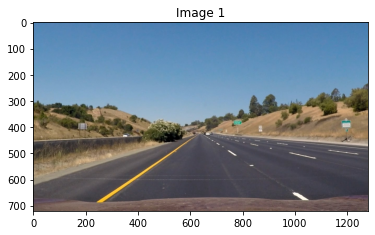

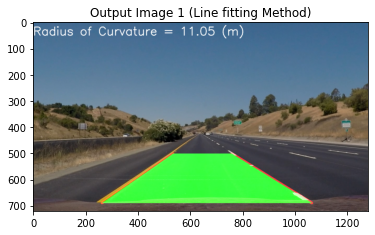

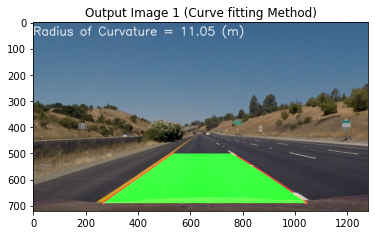

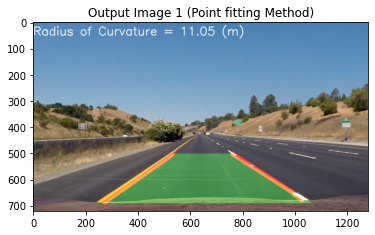

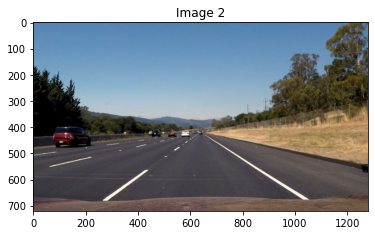

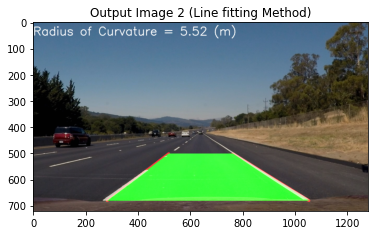

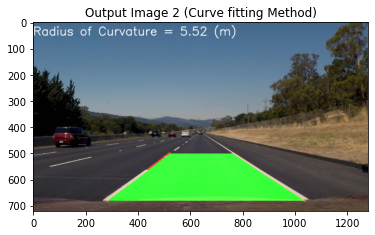

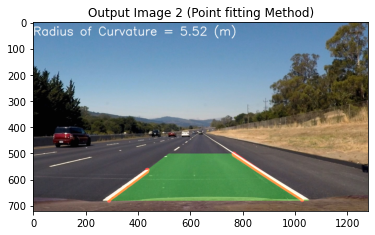

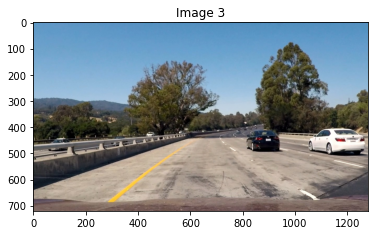

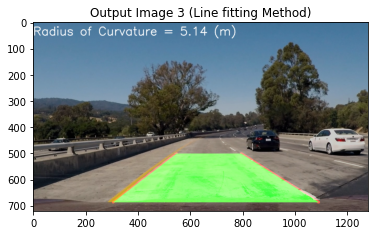

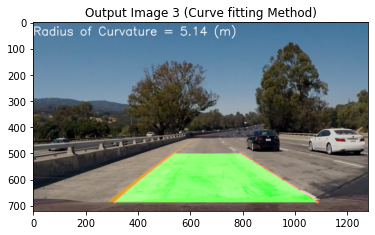

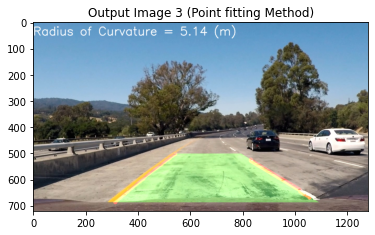

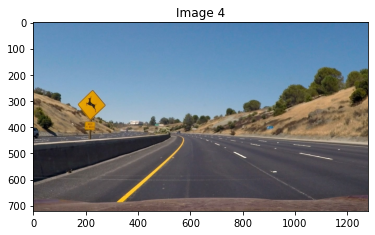

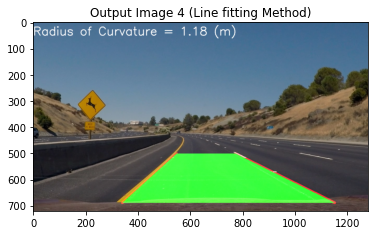

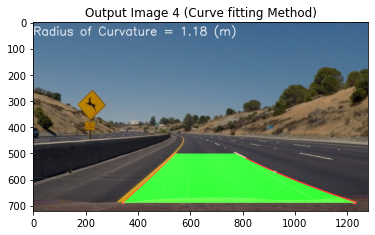

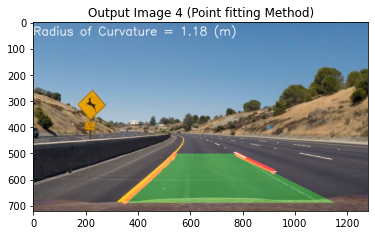

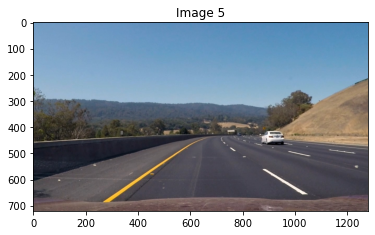

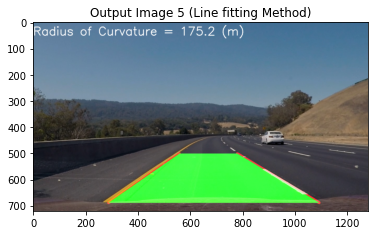

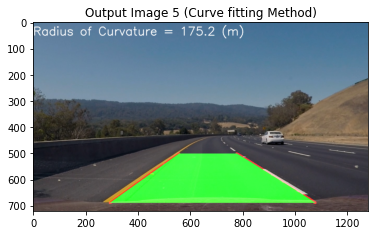

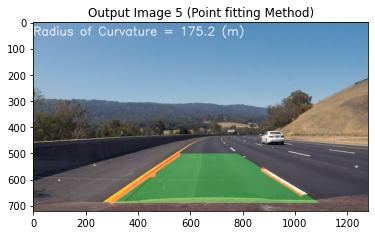

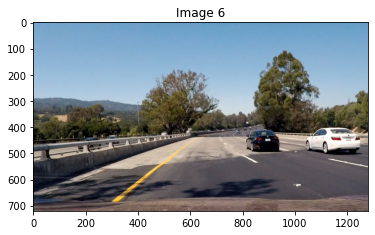

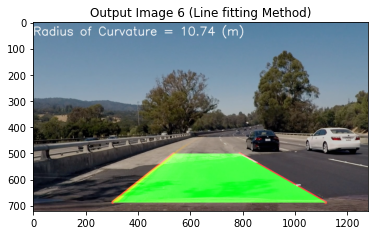

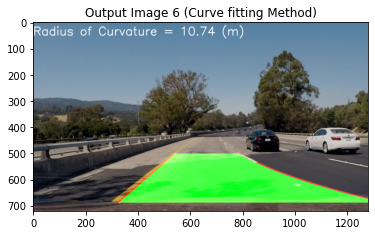

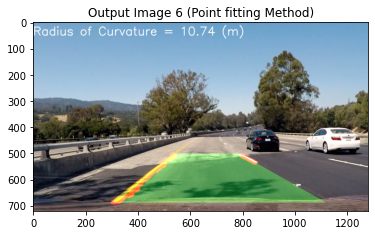

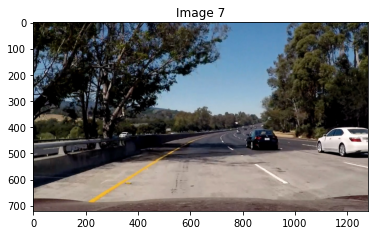

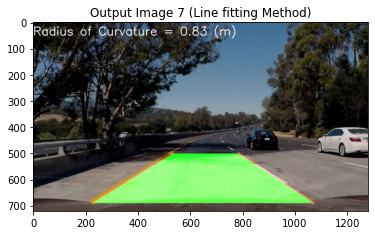

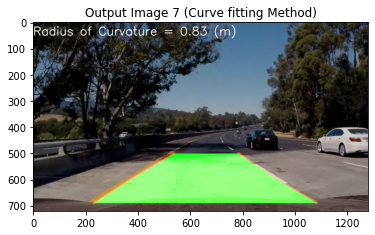

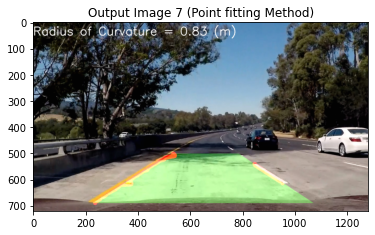

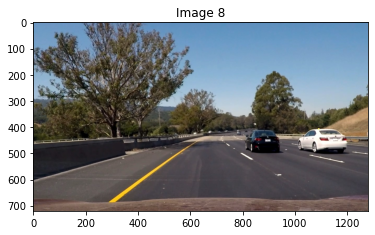

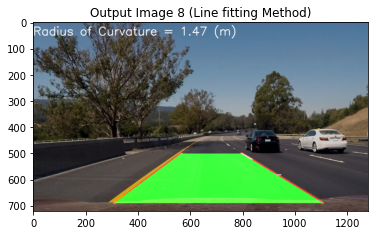

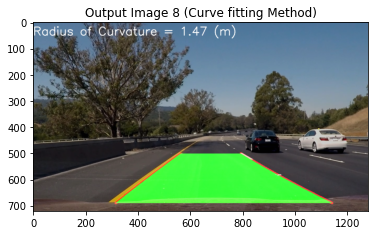

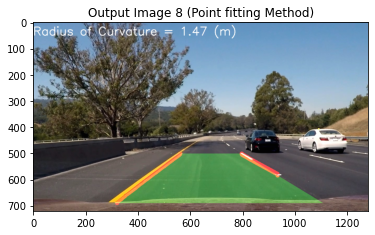

In [43]:
debugger = False

# Reading All images in the folder
images_paths = glob.glob("media/test_images/*.jpg")
images = [plt.imread(image) for image in images_paths]

# Choosing the method
#Method 1 --> Line fitting Method
#Method 2 --> Curve fitting Method
#Method 3 --> Point fitting Method
#Method 4 --> All Methods
method = 4

if (method == 4):
    plt.rcParams['figure.max_open_warning'] = 4 * len(images)

if (debugger):
    plt.rcParams['figure.max_open_warning'] = 10000

for image_idx in range(len(images)):
    show_image(images[image_idx], "Image "+str(image_idx +1))
    Result = pipeline(images[image_idx],method,debugger)
    # Checks if something is returned
    if (is_notEmpty(Result)):
        if (method == 1):
            show_image(Result,"Output Image "+str(image_idx +1)+" (Line fitting Method)")
        elif(method == 2):
            show_image(Result,"Output Image "+str(image_idx +1)+" (Curve fitting Method)")
        elif(method == 3):
            show_image(Result,"Output Image "+str(image_idx +1)+" (Point fitting Method)")
        elif(method == 4):
            show_image(Result[0],"Output Image "+str(image_idx +1)+" (Line fitting Method)")
            show_image(Result[1],"Output Image "+str(image_idx +1)+" (Curve fitting Method)")
            show_image(Result[2],"Output Image "+str(image_idx +1)+" (Point fitting Method)")
    else: # Nothing is returned
        print("The image has error in detecting lane")

In [44]:
VideoFlag = False # True -- > Need Video Processing
debugger = False

# Choosing the method
#Method 1 --> Line fitting Method
#Method 2 --> Curve fitting Method
#Method 3 --> Point fitting Method
#Method 4 --> All Methods
method = 4

if (VideoFlag):
    video_paths = glob.glob("media/*.mp4")
    videos = [cv2.VideoCapture(video) for video in video_paths]

    for i in range(len(videos)):
        numOfFrames = -1 # put -1 to do all the video
        startFrame = 0
        frames, fps, frameCount = videoToFrames(videos[i],startFrame,numOfFrames)
        
        if (numOfFrames != -1):
            frameCount = numOfFrames
            
        if (method == 4):
                framesM1 = np.copy(frames)
                framesM2 = np.copy(frames)
                framesM3 = np.copy(frames)
        else:
                newframes = np.copy(frames)
        
        plt.rcParams['figure.max_open_warning'] = fps * 3
        # Uncomment Below to Show all frames in the range
        #         for j, frame in enumerate(frames):
        #             show_image(frame,"Video "+ str(i+1) + " Frame "+ str(j+1+startFrame))
        
        # Do the pipeline operation on each frame
        for j, frame in enumerate(frames):
            Result = pipeline(frames[j],method,debugger)
            if (method ==4):
                if (is_notEmpty(Result)):
                    framesM1[j] = Result[0]
                    framesM2[j] = Result[1]
                    framesM3[j] = Result[2]
                    print("Output Video",(i+1),": The frame", str(j+1),"out of ", (frameCount),"is done processing")
                else:
                    print("Output Video",(i+1),": The frame",(j+1),"has error in detecting lane")
                    if (j != 0):
                        framesM1[j] = framesM1[j-1]
                        framesM2[j] = framesM2[j-1]
                        framesM3[j] = framesM3[j-1]
            else:    
                if (is_notEmpty(Result)):
                    newframes[j] = Result
                    print("Output Video",(i+1),": The frame", (j+1),"out of", (frameCount),"is done processing")
                else:
                    print("Output Video",(i+1),": The frame",(j+1),"out of",(frameCount),"has error in detecting lane")
                    if (j != 0):
                        newframes[j] = newframes[j-1]
        
        # Combine the frames       
        if (method ==4):
                if (is_notEmpty(framesM1)):
                    makeVideo(framesM1,fps,"Output Video "+str(i+1)+" (Line fitting Method)")
                else:
                    print("Output Video "+str(i+1)+" (Line fitting Method) has failed in processing")
                
                if (is_notEmpty(framesM2)):
                    makeVideo(framesM2,fps,"Output Video "+str(i+1)+" (Curve fitting Method)")
                else:
                    print("Output Video "+str(i+1)+" (Curve fitting Method) has failed in processing")
                    
                if (is_notEmpty(framesM3)):
                    makeVideo(framesM3,fps,"Output Video "+str(i+1)+" (Point fitting Method)")
                else:
                    print("Output Video "+str(i+1)+" (Point fitting Method) has failed in processing")
        else:     
                if (is_notEmpty(newframes)):
                    makeVideo(newframes,fps,"Output Video "+str(i+1))
                else:
                    print("Output Video "+str(i+1)+" has failed in processing")